In [246]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt

from sklearn.externals import joblib

from sklearn.ensemble import(
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor
)

from sklearn.preprocessing import(
    scale,
    LabelEncoder
)
from sklearn.decomposition import PCA

from sklearn.model_selection import(
    train_test_split,
    cross_val_score,
    GridSearchCV
)
from sklearn.metrics import(
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score
)
%matplotlib inline

from sklearn.linear_model import(
    LassoCV,
    ElasticNetCV
) 

from scipy.stats import skew

In [226]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [233]:
# train["SalePrice"] = np.log1p(train["SalePrice"])

numeric_feats = train.dtypes[train.dtypes != "object"].index

# Applying logarithmic transform to skewed features
# This code was pulled from Alexandru Papiu:
# https://www.kaggle.com/apapiu/regularized-linear-models

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
train[skewed_feats] = np.log1p(train[skewed_feats])

# Getting dummy variables
train_dummies = pd.get_dummies(train)
train_dummies = train_dummies.fillna(train_dummies.mean())

# Splitting train df into train and test data
train_X = train_dummies.loc[:, train_dummies.columns != 'SalePrice']
train_y = train_dummies["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y)

In [234]:

# Calculate RMSE
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 3))
    return(rmse)

model_lasso = LassoCV(normalize=True).fit(X_train, y_train)
print(rmse_cv(model_lasso).mean())
model_lasso.score(X_test, y_test)

0.121207824266


0.89811462759861904

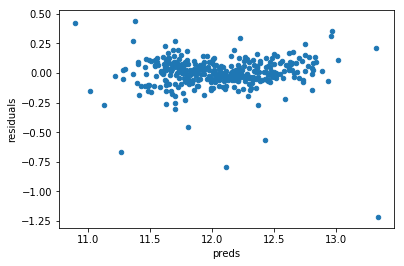

In [235]:
preds = pd.DataFrame({"preds":model_lasso.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [206]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_regression, mutual_info_regression


# fvalue_selector = SelectKBest(mutual_info_regression, k=9)
# X_kbest = fvalue_selector.fit_transform(train_X, train_y)
# X_train, X_test, y_train, y_test = train_test_split(X_kbest, train_y)
# model_lasso = LassoCV(normalize=True).fit(X_train, y_train)
# rmse_cv(model_lasso).mean()
# model_lasso.score(X_test, y_test)

In [236]:
rf = RandomForestRegressor(max_features=25, n_estimators=500)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.86918566312168888

In [ ]:
# cross_vals = {}
# for i in range(11,12):
#     rf = RandomForestRegressor(max_depth=9, max_features=6, random_state=10, n_estimators=500)
#     cross_val_mean = np.mean(cross_val_score(rf, X_train, y_train, cv=10))
#     cross_vals[str(i)] = cross_val_mean
#     print(f"10-fold cv score mean with max_depth {i}: {cross_val_mean}")

In [ ]:
# grid_search.fit(X_train,y_train)
# rf = RandomForestRegressor()
# parameters = {"max_depth": [9,10,11,12],
#               "min_samples_split" :[2,3,4,5,6],
#               "n_estimators" : [100,500],
#               "max_features": (4,5,6)}
# grid_search = GridSearchCV(rf, parameters, n_jobs=3, cv=5)
#grid_search_CV = joblib.dump(grid_search, "grid_search_dummies.pkl")

In [96]:
# Random Forest Feature-Coefficient Dataframe
# fcdf = pd.DataFrame.from_dict(dict(zip(list(X_train.columns), list(rf.feature_importances_))), orient="index").sort_values(by=0,ascending=False)

# Gradient Boosting Regressor

In [243]:
gboost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=9, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, loss='huber')
gboost.fit(X_train, y_train)

# Prints R2 and RMSE scores
def get_score(pred, y):
    print('R2: {}'.format(r2_score(pred, y)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(pred, y))))

# Shows scores for train and validation sets    
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    pred_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    print("Train")
    print("-"*25)
    # Printing train scores
    get_score(pred_train, y_trn)
    pred_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    print("-"*25)
    get_score(pred_test, y_tst)

train_test(gboost, X_train, X_test, y_train, y_test)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=9,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=15,
             min_samples_split=10, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
Train
-------------------------
R2: 0.9821448350997466
RMSE: 0.05055382506014749
Test
-------------------------
R2: 0.8684252137873668
RMSE: 0.14148937000236525


In [244]:
scores = cross_val_score(gboost, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.90 (+/- 0.04)


In [245]:
combined_pred = (gboost.predict(X_test) + model_lasso.predict(X_test)) / 2
print('R2: {}'.format(r2_score(combined_pred, y_test)))

R2: 0.8837422840159325


In [267]:
elastic_net = ElasticNetCV(alphas=[.0001, .000001],
                           l1_ratio=[.01, .1, .5, .9, .99],
                           max_iter=5000,
                           
                          )

In [268]:
elastic_net.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNetCV(alphas=[0.0001, 1e-06], copy_X=True, cv=None, eps=0.001,
       fit_intercept=True, l1_ratio=[0.01, 0.1, 0.5, 0.9, 0.99],
       max_iter=5000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [269]:
train_test(elastic_net, X_train, X_test, y_train, y_test)

ElasticNetCV(alphas=[0.0001, 1e-06], copy_X=True, cv=None, eps=0.001,
       fit_intercept=True, l1_ratio=[0.01, 0.1, 0.5, 0.9, 0.99],
       max_iter=5000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)
Train
-------------------------
R2: 0.9473778067412635
RMSE: 0.08672301070595069
Test
-------------------------
R2: 0.8939235278881271
RMSE: 0.13470423440275614


In [271]:
combined_pred = (gboost.predict(X_test) + elastic_net.predict(X_test)) / 2
print('R2: {}'.format(r2_score(combined_pred, y_test)))

R2: 0.8900839587314229


## Filter by Variance Inflation Factor
This takes too long to process for all features, commented out atm.

In [275]:
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.preprocessing import Imputer
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# class ReduceVIF(BaseEstimator, TransformerMixin):
#     def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
#         # From looking at documentation, values between 5 and 10 are "okay".
#         # Above 10 is too high and so should be removed.
#         self.thresh = thresh
        
#         # The statsmodel function will fail with NaN values, as such we have to impute them.
#         # By default we impute using the median value.
#         # This imputation could be taken out and added as part of an sklearn Pipeline.
#         if impute:
#             self.imputer = Imputer(strategy=impute_strategy)

#     def fit(self, X, y=None):
#         print('ReduceVIF fit')
#         if hasattr(self, 'imputer'):
#             self.imputer.fit(X)
#         return self

#     def transform(self, X, y=None):
#         print('ReduceVIF transform')
#         columns = X.columns.tolist()
#         if hasattr(self, 'imputer'):
#             X = pd.DataFrame(self.imputer.transform(X), columns=columns)
#         return ReduceVIF.calculate_vif(X, self.thresh)

#     @staticmethod
#     def calculate_vif(X, thresh=5.0):
#         # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
#         dropped=True
#         while dropped:
#             variables = X.columns
#             dropped = False
#             vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
#             max_vif = max(vif)
#             if max_vif > thresh:
#                 maxloc = vif.index(max_vif)
#                 print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
#                 X = X.drop([X.columns.tolist()[maxloc]], axis=1)
#                 dropped=True
#         return X
# transformer = ReduceVIF()

# X_transform = transformer.fit_transform(train_X, train_y)

# X_transform.head()